 Zehra HİÇYILMAZ

- **Amaç:** IMDB film yorumlarını pozitif veya negatif olarak sınıflandırmak.  
- **Veri Seti:** IMDB Dataset of 50K Movie Reviews.  
- **Model:** LSTM (Long Short-Term Memory).  
- **Algoritma:** Adam optimizasyon algoritması ile derin öğrenme.  
- **Performans:** Eğitim doğruluğu %90.9, test doğruluğu %87.4.  

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import f1_score, recall_score

In [ ]:
from google.colab import files


files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zehraerva","key":"c50b68fb59310f2fef7adc73186b1a92"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
 89% 23.0M/25.7M [00:00<00:00, 107MB/s] 
100% 25.7M/25.7M [00:00<00:00, 98.1MB/s]


In [ ]:
!unzip imdb-dataset-of-50k-movie-reviews.zip

Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


**Stopwords** :Doğal dil işleme projelerinde, "ve", "ama", "bir", "gibi" gibi genellikle anlam taşımayan kelimelerdir.
Metin analizinde bu kelimeler filtrelenerek modelin daha anlamlı kelimeler üzerinde çalışması sağlanır.

**Wordnet :** Kelimeleri kök hallerine (lemma) dönüştürmek için kullanılır.

In [ ]:
# NLTK veri setlerini indirmek için
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Verinin temizlenmesi fonksiyonu
def clean_text(text):
    # Küçük harfe dönüştürme
    text = text.lower()

    # Sayılardan temizleme
    text = re.sub(r'\d+', '', text)

    # Özel karakterlerden temizleme
    text = re.sub(r'[^\w\s]', '', text)

    # Fazla boşlukları kaldırma
    text = re.sub(r'\s+', ' ', text).strip()

    # Stopwords kelimelerinden temizleme
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    # Lemmatizasyon (kelime köklerine indirgeme)
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    return text

Metni token'lara ayırarak sayısal bir diziye dönüştürür.

Modelden verilen metnin duygu analizine ilişkin bir olasılık değeri alır.
Tahmin sonucuna göre etiketleme yapar.

In [ ]:
# Kullanıcıdan yorum alıp tahmin etme fonksiyonu
def predict_sentiment(text):
    # Yorumun sayısal hale getirilmesi
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_length, padding='post')

    # Model ile tahmin yapma
    prediction = model.predict(padded)

    # Tahmin sonucuna göre pozitif veya negatif etiketleme
    if prediction > 0.5:
        return "Pozitif Yorum"
    else:
        return "Negatif Yorum"

Önce ve Sonrasına Örnek:

Ham Yorum: "I love this movie! It's amazing."

Temizlenmiş Yorum: "love movie amazing"

In [ ]:
# CSV dosyasını yükleyin
data = pd.read_csv('IMDB Dataset.csv')

# Yorumları temizleyelim
data['review'] = data['review'].apply(clean_text)

In [ ]:
# Etiketleri sayısal formata dönüştürme (positive -> 1, negative -> 0)
data['sentiment'] = data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Veriyi eğitim ve test olarak ayırma
X = data['review']
y = data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Neden önemli?

Bazı işlemler sırasında etiketler float64 veya object türünde olabilir. Özellikle TensorFlow veya diğer derin öğrenme kütüphanelerinde, etiketlerin tam sayı (int) türünde olması gereklidir.

In [ ]:
# Etiketlerin sayısal formata dönüştüğünden emin olalım (int türünde)
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')


 Metin verisini analiz edilebilir bir sayısal forma dönüştürmek.

  Örneğin bu kodda en sık geçen ilk 5000 kelimeyi dikkate alır. Daha nadir kelimeler göz ardı edilir.

 Tokenizer, metin verisindeki kelimeleri sıklıklarına göre sıralar ve bir "kelime-sayı" sözlüğü oluşturur.

 Daha sık geçen kelimeler daha düşük indekslere atanır.

In [ ]:
# Tokenizer oluşturma ve veriyi sayısal hale getirme
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

Tüm dizilerin aynı uzunlukta olmasını sağlamak (model giriş boyutuyla uyumlu hale getirmek).

Bu örnekte dizilerin maksimum uzunluğu 100 olarak ayarlanır. Daha uzun diziler kesilir, daha kısa diziler sıfırlarla doldurulur.

In [ ]:
# Veriyi sıralama ve padding yapma
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_length = 100  # Cümlelerin maksimum uzunluğu
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

Sequential: Her katman bir önceki katmanın çıktısını giriş olarak alır.

Embedding Katmanı:Kelimeleri yoğun (dense) bir vektör uzayında temsil etmek.

Bu, modelin kelimeler arasındaki ilişkileri öğrenmesine yardımcı olur.

Dense Katmanı: Çıkışı bir sınıfa (pozitif veya negatif) sınıflandırır.



In [ ]:
# LSTM modelini oluşturma
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_length))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(





**NEDEN LSTM?**

LSTM'ler, sıradan RNN'lere kıyasla uzun süreli bağımlılıkları daha iyi öğrenebilir.

RNN'lerde, gradyanların kaybolması (vanishing gradient) nedeniyle uzun sekanslardaki bilgiyi öğrenmek zorlaşır.
LSTM, içsel yapısındaki kapılar (gates) sayesinde bu sorunu çözerek daha verimli öğrenir.

In [ ]:
# Modeli derleme
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Modeli eğitme
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test))


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 190s 298ms/step - accuracy: 0.5960 - loss: 0.6602 - val_accuracy: 0.6811 - val_loss: 0.6059
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 181s 290ms/step - accuracy: 0.7378 - loss: 0.5342 - val_accuracy: 0.8444 - val_loss: 0.3691
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 166s 266ms/step - accuracy: 0.8638 - loss: 0.3385 - val_accuracy: 0.8621 - val_loss: 0.3201
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 166s 266ms/step - accuracy: 0.8950 - loss: 0.2642 - val_accuracy: 0.8771 - val_loss: 0.2913
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 205s 272ms/step - accuracy: 0.9094 - loss: 0.2359 - val_accuracy: 0.8739 - val_loss: 0.3052


**Neden binary cross-entropy?**

Projede ikili sınıflandırma yapıyoruz (pozitif ve negatif yorumlar). Bu nedenle, binary cross-entropy en uygun kayıp fonksiyonudur.

**Neden Adam?**

Adam, uyarlanabilir öğrenme oranı kullanarak daha hızlı ve daha stabil öğrenme sağlar.

In [ ]:
# Eğitim ve doğrulama doğruluğunu yazdırma
print("Eğitim doğruluğu: ", history.history['accuracy'][-1])
print("Eğitim kaybı: ", history.history['loss'][-1])
print("Doğrulama doğruluğu: ", history.history['val_accuracy'][-1])
print("Doğrulama kaybı: ", history.history['val_loss'][-1])

Eğitim doğruluğu:  0.9087250232696533
Eğitim kaybı:  0.2368960976600647
Doğrulama doğruluğu:  0.8738999962806702
Doğrulama kaybı:  0.3052249550819397


In [ ]:
# Eğitim ve doğrulama doğruluğu grafiklerini çizme
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

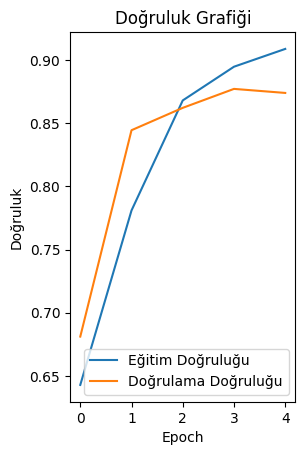

In [ ]:
# Accuracy grafik
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Doğruluk Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

Eğitim ve doğrulama doğrulukları düzenli bir şekilde artarken, birbirine yakın seyretmesi, modelin genelleme yeteneğinin güçlü olduğunu ve overfitting yapmadığını göstermektedir.

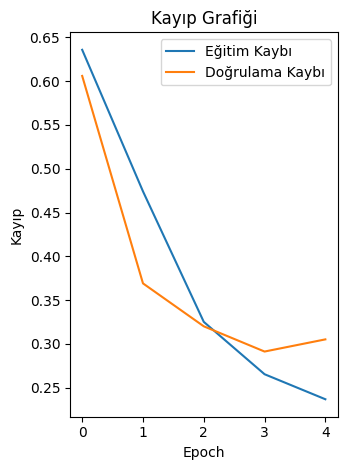

In [ ]:
# Loss grafik
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Kayıp Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.tight_layout()
plt.show()


Eğitim ve doğrulama kayıpları zamanla azalış gösteriyor.

In [ ]:
# Confusion Matrix çizimi
y_pred = (model.predict(X_test_pad) > 0.5).astype(int)  # Tahminler
cm = confusion_matrix(y_test, y_pred)

# F1 ve Recall değerlerini hesaplayalım
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"F1 Skoru: {f1}")
print(f"Recall Değeri: {recall}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step
F1 Skoru: 0.879778815902374
Recall Değeri: 0.9156578686247271


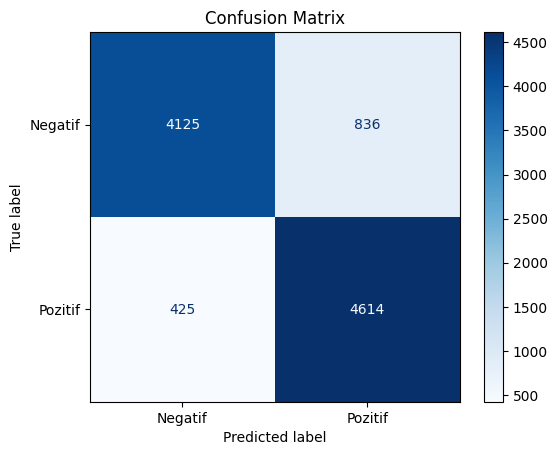

In [ ]:
# Confusion Matrix görselleştirme
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatif', 'Pozitif'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

Genel olarak dengeli bir dağılım var.

10.000 Veriden:

8739 Doğru Tahmin

1261 Yanlış Tahmin

In [ ]:
# Test: Kullanıcıdan yorum alıp tahmin etme
user_comment = input("Bir film yorumu girin: ")
sentiment = predict_sentiment(user_comment)
print("Modelin tahmini: ", sentiment)

Bir film yorumu girin: "The movie was fantastic! The plot was engaging, the characters were well-developed, and the pacing was perfect. The visuals were stunning, and the performances were incredibly compelling. A must-watch!"
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Modelin tahmini:  Pozitif Yorum
